In [1]:
import sympy as sym
from sympy import S
import math
sym.init_printing()

<div>
<img src="../docs/FK_diagram_1.jpg" width="360"/>
</div>

Let's look at the parallel five-bar linkage up-side down from the robot for a better view.
Since q1, q2, l1, l2, l1', l2', and d are known, we can represent point A and point B's coordinates as follow:

$x_A = d + l_1cos(q_1)$ &nbsp;&nbsp;&nbsp; (1)

$y_A = l_1\cdot sin(q_1)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (2)

$x_B = l_1^{'}\cdot cos(q_2)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (3)

$y_B = l_1^{'}\cdot sin(q_2)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (4)

In [2]:
X, Y, Xa, Ya, Xb, Yb, q1, q2, l1, l2, l1p, l2p, d = sym.symbols('X, Y, Xa, Ya, Xb, Yb, q1, q2, l1, l2, l1p, l2p, d', real=True)

Eq1 = sym.Eq(d+l1*sym.cos(q1), Xa)
Eq2 = sym.Eq(  l1*sym.sin(q1), Ya)
Eq3 = sym.Eq( l1p*sym.cos(q2), Xb)
Eq4 = sym.Eq( l1p*sym.sin(q2), Yb)

sym.solve([Eq1,Eq2,Eq3,Eq4], (Xa,Ya,Xb,Yb))

<div>
<img src="../docs/FK_diagram_2.jpg" width="540"/>
</div>

To find the coordinate of point C, we can think of it as one of the intersections of two circles in the xy coordinate system. The two circles can be written as:

$l_2^2 = (x - x_A)^2 + (y - y_A)^2$    &nbsp;&nbsp;&nbsp;&nbsp; (5)

$l_2^{'2} = (x - x_B)^2 + (y - y_B)^2$ &nbsp;&nbsp;&nbsp; (6)

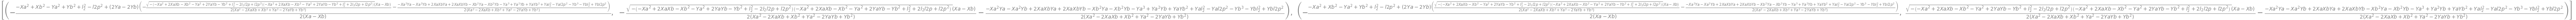

In [3]:
Eq5 = sym.Eq( l2**2, (X - Xa)**2+(Y - Ya)**2)
Eq6 = sym.Eq(l2p**2, (X - Xb)**2+(Y - Yb)**2)

sym.solve([Eq5,Eq6], (X,Y))

This pure algebraic solution looks overly complicated. Luckily, it becomes much more manageable once we plug in all known values.

In [5]:
# Input known values here
q1  = 45
q2  = 120
d   = 20
l1  = 25
l1p = 25
l2  = 35
l2p = 35

# Convert deg to rad
q1 = q1 * math.pi / 180
q2 = q2 * math.pi / 180

Eq1 = sym.Eq(d+l1*sym.cos(q1), Xa)
Eq2 = sym.Eq(  l1*sym.sin(q1), Ya)
Eq3 = sym.Eq( l1p*sym.cos(q2), Xb)
Eq4 = sym.Eq( l1p*sym.sin(q2), Yb)
soln_1 = sym.solve([Eq1,Eq2,Eq3,Eq4], (Xa,Ya,Xb,Yb))

Xa, Ya, Xb, Yb = round(soln_1[Xa],2), round(soln_1[Ya],2), round(soln_1[Xb],2), round(soln_1[Yb],2)
print(Xa, Ya, Xb, Yb)

TypeError: list indices must be integers or slices, not Float

In [6]:
Eq7 = sym.Eq( l2**2, (X - Xa)**2 + (Y - Ya)**2)
Eq8 = sym.Eq(l2p**2, (X - Xb)**2 + (Y - Yb)**2)

soln_2 = sym.solve([Eq7,Eq8], (X,Y))
print(soln_2)

[(10.6733246744563, -4.58026509751920), (14.5087365749702, 43.9104030658175)]


This takes about 10 seconds. Not ideal. Let's try to optimize. By using scipy instead of sympy, we can solve the same equation much faster.

In [7]:
import math
import numpy as np
from scipy.optimize import fsolve

# Input known values here
q1  = 12
q2  = 168
d   = 19.5
l1  = 25
l1p = 25
l2  = 35
l2p = 35

# Convert deg to rad
q1 = q1 * math.pi / 180
q2 = q2 * math.pi / 180

# Using scipy's fsolve, which is known to be faster at this type of calculation
def func(x, *angle):
    Q1, Q2 = angle
    Xa = l1 * math.cos(Q1) + d
    Ya = l1 * math.sin(Q1)
    Xb = l1p * math.cos(Q2)
    Yb = l1p * math.sin(Q2)
    return [x[0]*x[0] - 2*x[0]*Xa + Xa**2 + x[1]*x[1] - 2*x[1]*Ya + Ya**2 - l2*l2,
            x[0]*x[0] - 2*x[0]*Xb + Xb**2 + x[1]*x[1] - 2*x[1]*Yb + Yb**2 - l2p*l2p]

angle = (q1, q2)
x, y = fsolve(func, [10, 60], args=angle)
print(x, y)

9.75 12.621240871259987


This is great! However, keep in mind that if we ever need to run this with cpp on a microcontroller, we won't be able to use these fancy libraries. Therefore, it will be best if we can represent the coordinate of point C in an aggregated expression.

http://ambrnet.com/TrigoCalc/Circles2/circle2intersection/CircleCircleIntersection.htm

As a further investigation, I was interested in the relationship between the rate of change in y and the angles of the joints. Supposedly, using the angle interval where y is changing the fastest to perform a jump might be more efficient?

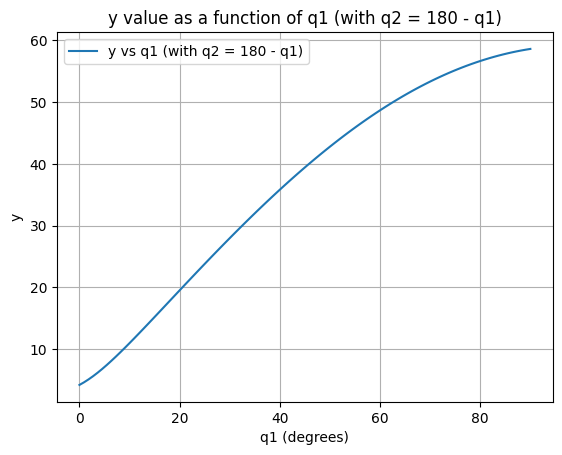

In [3]:
import math
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Define constants
d   = 19.5
l1  = 25
l1p = 25
l2  = 35
l2p = 35

# Function to solve the equations
def func(x, *angle):
    Q1, Q2 = angle
    Xa = l1 * math.cos(Q1) + d
    Ya = l1 * math.sin(Q1)
    Xb = l1p * math.cos(Q2)
    Yb = l1p * math.sin(Q2)
    return [x[0]*x[0] - 2*x[0]*Xa + Xa**2 + x[1]*x[1] - 2*x[1]*Ya + Ya**2 - l2*l2,
            x[0]*x[0] - 2*x[0]*Xb + Xb**2 + x[1]*x[1] - 2*x[1]*Yb + Yb**2 - l2p*l2p]

# Define the range for q1 and corresponding q2
q1_values = np.linspace(0, 90, 100)  # 100 points from 0 to 90 degrees
q2_values = 180 - q1_values          # q1 + q2 = 180 degrees

# Convert degrees to radians
q1_values_rad = np.deg2rad(q1_values)
q2_values_rad = np.deg2rad(q2_values)

# Initialize list to store y-values
y_values = []

# Solve for y for each pair (q1, q2)
for q1, q2 in zip(q1_values_rad, q2_values_rad):
    angle = (q1, q2)
    solution = fsolve(func, [10, 60], args=angle)
    y_values.append(solution[1])  # Store the y-value

# Plotting
plt.plot(q1_values, y_values, label='y vs q1 (with q2 = 180 - q1)')
plt.xlabel('q1 (degrees)')
plt.ylabel('y')
plt.title('y value as a function of q1 (with q2 = 180 - q1)')
plt.legend()
plt.grid(True)
plt.show()

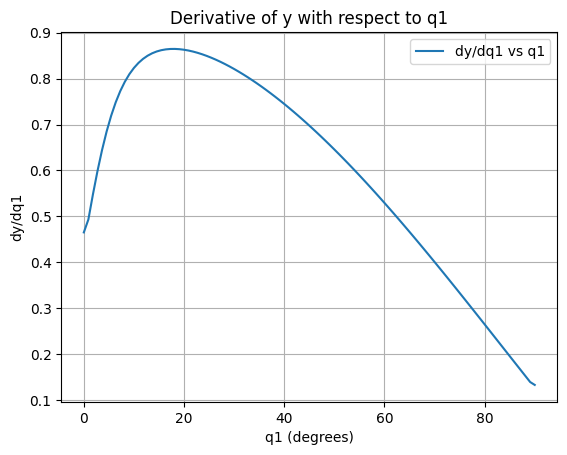

In [4]:
# Convert y_values to numpy array
y_values = np.array(y_values)

# Calculate the numerical derivative of y with respect to q1
dy_dq1 = np.gradient(y_values, q1_values)

# Plotting the derivative
plt.plot(q1_values, dy_dq1, label="dy/dq1 vs q1")
plt.xlabel('q1 (degrees)')
plt.ylabel('dy/dq1')
plt.title('Derivative of y with respect to q1')
plt.legend()
plt.grid(True)
plt.show()